# 6장 추천엔진 만들기 
    Overview of Siamese BERT Architectures 
    Fine-Tuning Siamese BERT for Recommendations 

데이터: [Anime Recommendation Database 2020](https://www.kaggle.com/datasets/hernan4444/anime-recommendation-database-2020?select=rating_complete.csv)

# 0. 관련 자료 정리

In [1]:
import pandas as pd

# 1. 데이터 로딩

In [2]:
pre_merged_anime = pd.read_csv('../data/pre_merged_anime.csv').dropna()
print(pre_merged_anime.shape)
pre_merged_anime.head(2)

(16206, 19)


,MAL_ID,Name,Score,Genres,English name,Type,Episodes,Premiered,Producers,Studios,Source,Duration,Rating,Ranked,Members,Favorites,Completed,On-Hold,synopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,TV,26,Spring 1998,Bandai Visual,Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,1251960,61971,718161,71513,"In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,Movie,1,Unknown,"Sunrise, Bandai Visual",Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,273145,1174,208333,1935,"other day, another bounty—such is the life of ..."


In [3]:
import re
import string

def clean_text(text):
    # 인쇄할 수 없는 문자 제거
    text = ''.join(filter(lambda x: x in string.printable, text))
    
    # 여러 개의 공백 문자를 하나의 공백으로 바꾸기
    text = re.sub(r'\s{2,}', ' ', text).strip()

    return text.strip()


def get_anime_description(anime_row):
    """
    입력 데이터의 다양한 기능을 기반으로 애니메이션 제목에 대한 사용자 지정 설명을 생성합니다.

    :param anime_row: 관련 애니메이션 정보가 포함된 MyAnimeList 데이터 세트의 행입니다.
    :return: 애니메이션에 대한 사용자 지정 설명이 포함된 형식화된 문자열입니다.
    """

    # 애니메이션 유형(TV 프로그램 또는 기타)을 결정합니다.
    anime_type = "TV Show" if anime_row["Type"] == "TV" else anime_row["Type"]

    # 입력 데이터의 관련 기능을 사용하여 형식이 지정된 설명을 작성합니다.
    description = (
        f"{anime_row['Name']} is a {anime_type}.\n"
        f"Synopsis: {anime_row['synopsis']}\n"
        f"It was produced by {anime_row['Producers']} and it is from {anime_row['Studios']} Studio.\n"
        f"Its source is {anime_row['Source']}.\n"
        f"It premiered in {anime_row['Premiered']}.\n"
        f"Its genres are {anime_row['Genres']}\n"
    )

    return clean_text(description)


In [4]:
print(clean_text(get_anime_description(pre_merged_anime.iloc[0])))

Cowboy Bebop is a TV Show.
Synopsis: In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as "Cowboys." The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travelsEin, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wongthe crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Be

In [5]:
pre_merged_anime['generated_description'] = pre_merged_anime.apply(get_anime_description, axis=1)

In [6]:
pre_merged_anime

,MAL_ID,Name,Score,Genres,English name,Type,Episodes,Premiered,Producers,Studios,Source,Duration,Rating,Ranked,Members,Favorites,Completed,On-Hold,synopsis,generated_description
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,TV,26,Spring 1998,Bandai Visual,Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,1251960,61971,718161,71513,"In the year 2071, humanity has colonized sever...",Cowboy Bebop is a TV Show.\nSynopsis: In the y...
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,Movie,1,Unknown,"Sunrise, Bandai Visual",Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,273145,1174,208333,1935,"other day, another bounty—such is the life of ...",Cowboy Bebop: Tengoku no Tobira is a Movie.\nS...
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,TV,26,Spring 1998,Victor Entertainment,Madhouse,Manga,24 min. per ep.,PG-13 - Teens 13 or older,266.0,558913,12944,343492,25465,"Vash the Stampede is the man with a $$60,000,0...",Trigun is a TV Show.\nSynopsis: Vash the Stamp...
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,TV,26,Summer 2002,"TV Tokyo, Bandai Visual, Dentsu, Victor Entert...",Sunrise,Original,25 min. per ep.,PG-13 - Teens 13 or older,2481.0,94683,587,46165,5121,ches are individuals with special powers like ...,Witch Hunter Robin is a TV Show.\nSynopsis: ch...
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,TV,52,Fall 2004,"TV Tokyo, Dentsu",Toei Animation,Manga,23 min. per ep.,PG - Children,3710.0,13224,18,7314,766,It is the dark century and the people are suff...,Bouken Ou Beet is a TV Show.\nSynopsis: It is ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16201,48481,Daomu Biji Zhi Qinling Shen Shu,Unknown,"Adventure, Mystery, Supernatural",Unknown,ONA,Unknown,Unknown,Unknown,Unknown,Novel,Unknown,Unknown,Unknown,354,6,0,0,No synopsis information has been added to this...,Daomu Biji Zhi Qinling Shen Shu is a ONA.\nSyn...
16202,48483,Mieruko-chan,Unknown,"Comedy, Horror, Supernatural",Unknown,TV,Unknown,Unknown,Kadokawa,Passione,Manga,Unknown,Unknown,Unknown,7010,70,0,14,ko is a typical high school student whose life...,Mieruko-chan is a TV Show.\nSynopsis: ko is a ...
16203,48488,Higurashi no Naku Koro ni Sotsu,Unknown,"Mystery, Dementia, Horror, Psychological, Supe...",Higurashi:When They Cry – SOTSU,TV,Unknown,Summer 2021,Unknown,Unknown,Visual novel,Unknown,R - 17+ (violence & profanity),Unknown,11309,48,0,0,Sequel to Higurashi no Naku Koro ni Gou .,Higurashi no Naku Koro ni Sotsu is a TV Show.\...
16204,48491,Yama no Susume: Next Summit,Unknown,"Adventure, Slice of Life, Comedy",Unknown,TV,Unknown,Unknown,Kadokawa,8bit,Manga,Unknown,PG-13 - Teens 13 or older,Unknown,1386,2,2,2,New Yama no Susume anime.,Yama no Susume: Next Summit is a TV Show.\nSyn...


In [7]:
watching_status = pd.read_csv('../data/anime/watching_status.csv').dropna()
print(watching_status.shape)
watching_status

(5, 2)


,status,description
0,1,Currently Watching
1,2,Completed
2,3,On Hold
3,4,Dropped
4,6,Plan to Watch


In [11]:
rating_complete = pd.read_csv('../data/anime/rating_complete.csv').dropna()
print(rating_complete.shape)

(57633278, 3)


In [10]:
rating_complete.head(20)

,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9
5,0,431,8
6,0,578,10
7,0,433,6
8,0,1571,10
9,0,121,9


In [12]:
import numpy as np

rating_complete_train, rating_complete_test = \
              np.split(rating_complete.sample(frac=1, random_state=42), 
                       [int(.9*len(rating_complete))])

/Users/wlkim/anaconda3/envs/quick-start-guide-to-llms/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [13]:
rating_complete_train.head()

,user_id,anime_id,rating
41605545,255419,4059,7
33600014,206382,10793,7
39884414,245012,34246,4
45251042,277697,5030,7
53777062,329602,227,7


In [14]:
rating_complete_test.head()

,user_id,anime_id,rating
57039029,349749,154,9
33418394,205282,18001,9
18511337,113697,10110,9
53862736,330116,37520,7
30501411,187612,209,10


In [15]:
print(rating_complete_train.shape)
print(rating_complete_test.shape)

(51869950, 3)
(5763328, 3)


In [16]:
rating_complete_train.describe()

,user_id,anime_id,rating
count,5.186995e+07,5.186995e+07,5.186995e+07
mean,1.768898e+05,1.583165e+04,7.510736e+00
std,1.020080e+05,1.326141e+04,1.697711e+00
min,0.000000e+00,1.000000e+00,1.000000e+00
25%,8.828800e+04,3.091000e+03,7.000000e+00
50%,1.772940e+05,1.188700e+04,8.000000e+00
75%,2.654180e+05,2.899900e+04,9.000000e+00
max,3.534040e+05,4.845600e+04,1.000000e+01


<Axes: >

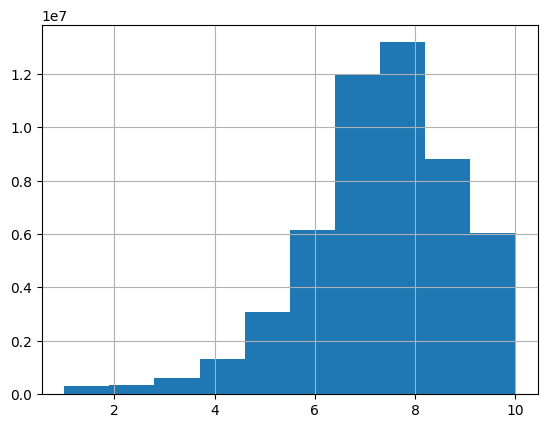

In [23]:
rating_complete_train["rating"].hist()

<Axes: >

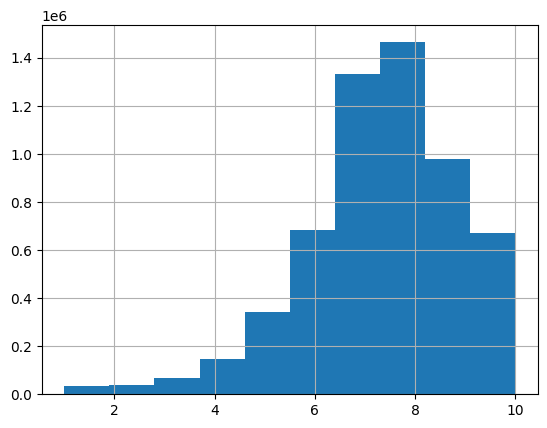

In [24]:
rating_complete_test["rating"].hist()

In [17]:
rating_complete_train.groupby('anime_id').count()

,user_id,rating
anime_id,,
1,71791,71791
5,30094,30094
6,42315,42315
7,9215,9215
8,1371,1371
...,...,...
47614,55,55
47616,1584,1584
47618,15,15


In [18]:
# 데이터 프레임을 anime_id로 그룹화하고 각 애니메이션에 해당하는 행 수를 계산합니다.
anime_counts = rating_complete_train.groupby('anime_id').count()

anime_counts['user_id'].describe()

count     16865.000000
mean       3075.597391
std        9275.477582
min           1.000000
25%          36.000000
50%         240.000000
75%        1506.000000
max      164244.000000
Name: user_id, dtype: float64

In [19]:
anime_counts.describe()

,user_id,rating
count,16865.000000,16865.000000
mean,3075.597391,3075.597391
std,9275.477582,9275.477582
min,1.000000,1.000000
25%,36.000000,36.000000
50%,240.000000,240.000000
75%,1506.000000,1506.000000
max,164244.000000,164244.000000


array([[<Axes: title={'center': 'user_id'}>,
        <Axes: title={'center': 'rating'}>]], dtype=object)

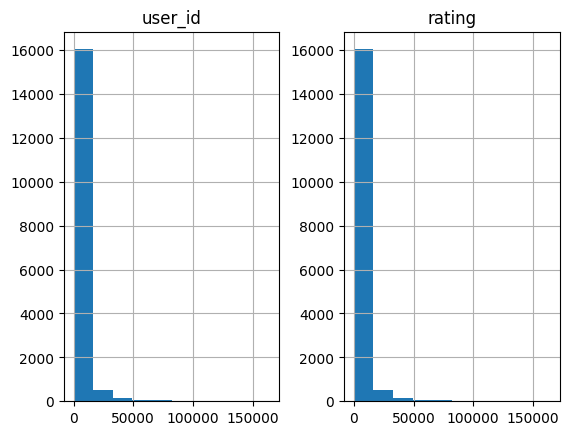

In [22]:
anime_counts.hist()

In [20]:
# 데이터 프레임을 user_id로 그룹화하고 각 애니메이션에 해당하는 행 수를 계산합니다.
user_counts = rating_complete_train.groupby('user_id').count()

user_counts['anime_id'].describe()

count    309426.000000
mean        167.632810
std         229.910583
min           1.000000
25%          39.000000
50%         102.000000
75%         214.000000
max       13955.000000
Name: anime_id, dtype: float64

In [13]:
# 고품질 데이터를 위해 240개 미만의 리뷰가 있는 애니메이션을 트레이닝 세트에서 제거하기

# 2. 콘텐츠 임베딩을 사용하여 타이틀 추천하기

In [21]:
!pip install dask dask-ml

In [25]:
score_map = {10: 1, 9: 1, 8: 0, 7: 0, 6: -1, 5: -1, 4:-1, 3:-1, 2:-1, 1:-1, 0:-1}

In [26]:
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

In [27]:
import pandas as pd
import itertools
import random

def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    if union:
        return intersection / union

# 긍정적인 예시에 대한 평점 임계값 설정하기
rating_threshold = 9

# 긍정적 평가 필터링
positive_ratings = rating_complete_train[rating_complete_train['rating'] >= rating_threshold]

# user_id와 긍정적으로 평가된 애니메이션의 사전을 만듭니다.
user_anime_dict = positive_ratings.groupby('user_id')['anime_id'].apply(set).to_dict()


# 모든 애니메이션 쌍 간의 자카드 유사도 계산하기
anime_pairs = itertools.combinations(sorted(set(pre_merged_anime['MAL_ID'].unique()) & set(rating_complete_train['anime_id'].unique())), 2)

In [28]:
anime_pairs

In [31]:
'''
이 스크립트는 각 예제가 한 쌍의 애니메이션으로 구성된 훈련 예제를 준비합니다. 
각 쌍에 대한 레이블은 쌍에 포함된 각 애니메이션을 좋아하는 사용자의 
애니메이션을 좋아하는 사용자의 자카드 유사도를 기반으로 합니다. Jaccard 유사도(>= 0.3)가 높으면 해당 애니메이션이 
애니메이션이 유사하다는 것을 의미하며(긍정적인 예), 낮은 Jaccard 유사도(<0.1)는 
애니메이션이 서로 다르다는 것을 의미합니다(부정적인 예시). 

스크립트는 각 긍정적 예시당 최대 5개의 부정적 예시 비율을 유지합니다.
'''
# 필요한 라이브러리 가져오기
from random import sample, seed
from sentence_transformers import InputExample

# 양수 및 음수 쌍 예제를 저장하기 위한 빈 목록 초기화하기
positive_pairs_examples, negative_pairs_examples = [], []

# 결과의 재현성을 보장하기 위해 랜덤 함수의 시드 값을 설정합니다.
seed(42)

# 각 애니메이션 쌍 반복
for a1, a2 in tqdm(anime_pairs):
    # 쌍의 애니메이션 중 하나라도 pre_merged_anime 데이터프레임 인덱스에서 찾을 수 없는 경우 현재 반복을 건너뜁니다.
    if a1 not in pre_merged_anime.index or a2 not in pre_merged_anime.index:
        continue

    # 애니메이션 a1과 애니메이션 a2를 좋아하는 사용자 집합 간의 Jaccard 유사도 계산하기
    j = jaccard_similarity(user_anime_dict.get(a1, set()), user_anime_dict.get(a2, set())) 

    # Jaccard 유사도가 0이 아닌 경우(즉, 일부 공통 사용자가 있는 경우)
    if j:
        # Jaccard 유사도가 0.3보다 크거나 같으면, 
        # 쌍이 긍정적인 예시로 간주되어 positive_pairs_examples 목록에 추가됩니다.
        if j >= 0.3:
            positive_pairs_examples.append(InputExample(texts=[pre_merged_anime.loc[a1]['generated_description'], pre_merged_anime.loc[a2]['generated_description']], label=1.))

        # 제이카드 유사도가 0.1 미만인 경우, 
        # 해당 쌍은 부정적인 예시로 간주되어 negative_pairs_examples 목록에 추가됩니다.
        elif j < 0.1:
            negative_pairs_examples.append(InputExample(texts=[pre_merged_anime.loc[a1]['generated_description'], pre_merged_anime.loc[a2]['generated_description']], label=0.))

            # 부정적인 예시 수가 긍정적인 예시 수의 5배를 넘지 않도록 합니다. 
            # 5:1 비율을 유지하기 위해 부정적인 예시를 섞고 목록을 잘라냅니다.
            if len(negative_pairs_examples) > len(positive_pairs_examples) * 5:
                random.shuffle(negative_pairs_examples)
                negative_pairs_examples = negative_pairs_examples[:len(positive_pairs_examples)]

0it [00:00, ?it/s]

In [19]:
positive_pairs_examples[0].__dict__

{'guid': '',
 'texts': ['Sunabouzu is a TV Show.\nSynopsis: The Great Kanto Desert, a sweltering wasteland of nothing but ruins and sand, is all that remains of post-apocalyptic Japan. The once fair population has been left to cling to the inhospitable dunes for survival. At least, that is the case for normal people. For those who have spent a little too long in the Kanto sun, the desert offers a wondrous opportunity to make a name for themselves. One such person is the masked handyman "Sunabouzu," or Desert Punk, who has forged a legendary reputation for always finishing his jobs, no matter the nature or cost. Cunning and ruthless, he has become a force of crude destruction to the other desert people. However, the "Vixen of the Desert," Junko Asagiri, discovers that Sunabouzu is not without his weaknesseshe is easily swayed by his insatiable lust for large-breasted desert babes. Following their chaotic adventures through the Kanto Desert, Sunabouzu features a bizarre cast of personali

In [20]:
negative_pairs_examples[0].__dict__

{'guid': '',
 'texts': ['Ano Hi no Kokoro wo Toraete is a ONA.\nSynopsis: The story is set in a town that preserves nature and its natural attractions using technology. It centers on a protagonist who has drifted apart from his childhood friend, and uses the FlatFormer to reconnect through time and space. (Source: ANN)\nIt was produced by A-1 Pictures, Omnibus Japan, Tohokushinsha Film Corporation, Sunrise Music Publishing and it is from Sunrise Studio.\nIts source is Original.\nIt premiered in Unknown.\nIts genres are Sci-Fi, Drama',
  'Precure Miracle Leap Movie: Minna to no Fushigi na Ichinichi is a Movie.\nSynopsis: The story begins when the protagonist Hikaru meets aliens Lala, Prunce, and Fuwa while watching the night sky. She learns of the Star Palace, where the 12 Star Princesses of the constellations kept the balance of the universe until they were attacked. Lala is searching for the legendary Precure warriors to help find the 12 scattered Princess Star Color Pens and revive t

In [21]:
len(positive_pairs_examples), len(negative_pairs_examples)

(1567, 4918)

In [22]:
# 네거티브 쌍 다운샘플링
if len(negative_pairs_examples) > len(positive_pairs_examples):
    random.shuffle(negative_pairs_examples)
    negative_pairs_examples = negative_pairs_examples[:len(positive_pairs_examples)]

In [23]:
len(positive_pairs_examples), len(negative_pairs_examples)

(1567, 1567)

In [24]:
from sklearn.model_selection import train_test_split

# 긍정적_쌍과 부정적_쌍이 이미 있다고 가정합니다.
train_positive_pairs, val_positive_pairs = train_test_split(positive_pairs_examples, test_size=0.2, random_state=42)
train_negative_pairs, val_negative_pairs = train_test_split(negative_pairs_examples, test_size=0.2, random_state=42)


# 3. paraphrase-distilroberta-base-v1 튜닝

## 3.1 모델 초기화

In [25]:
from sentence_transformers import SentenceTransformer, evaluation, losses

In [26]:
# 사전 학습된 SBERT 모델 로드
model = SentenceTransformer('paraphrase-distilroberta-base-v1')
model.max_seq_length = 384     # 컨텍스트 창을 384 토큰으로 변경합니다. 일반적으로 128입니다.
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

## 3.2 데이터 분석 및 학습 데이터 생성

Token indices sequence length is longer than the specified maximum sequence length for this model (689 > 512). Running this sequence through the model will result in indexing errors


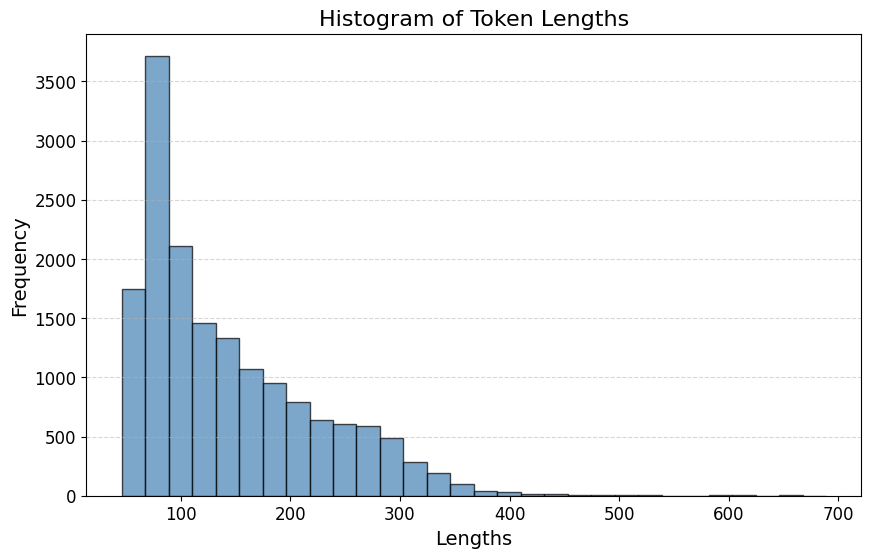

In [27]:
lengths = []
for c in pre_merged_anime['generated_description']:
    lengths.append(model.tokenizer(c, return_tensors='pt')['input_ids'].shape[1])
    
import pandas as pd
import matplotlib.pyplot as plt

# '상관 관계'가 데이터를 포함하는 사전이라고 가정합니다.

# 플롯과 히스토그램 설정
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=30, edgecolor='black', color='steelblue', alpha=0.7)

# 플롯의 모양 사용자 지정
plt.title("Histogram of Token Lengths", fontsize=16)
plt.xlabel("Lengths", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.5, linestyle='--')

# 히스토그램 표시
plt.show()


In [28]:
# 유효성 검사 집합에 양수 및 음수 쌍 결합하기
all_examples_val = val_positive_pairs + val_negative_pairs

# 유효성 검사 예제를 위한 데이터 로더 만들기
val_dataloader = DataLoader(
    all_examples_val,
    batch_size=16,
    shuffle=True
)

# 손실 함수 정의
loss = losses.CosineSimilarityLoss(model=model)

# 유효성 검사 예제에서 문장 및 점수 추출하기
val_sentences1 = [ex.texts[0] for ex in all_examples_val]
val_sentences2 = [ex.texts[1] for ex in all_examples_val]
val_scores = [ex.label for ex in all_examples_val]

# 평가자 만들기
evaluator = evaluation.EmbeddingSimilarityEvaluator(val_sentences1, val_sentences2, val_scores)

## 3.3 튜닝 전 모델 성능 측정

In [29]:
# 원래 아키텍처는 제한이 128이므로 너무 많은 컨텍스트가 잘립니다.
SentenceTransformer('paraphrase-distilroberta-base-v1').evaluate(evaluator)  

-0.18331345177468897

  2%|      | 5195/285789 [07:24<3:43:22, 20.94it/s]

In [30]:
model.evaluate(evaluator)

-0.029688522616121163

## 3.4 모델 학습

In [33]:
# 양수 및 음수 쌍 결합
train_examples = train_positive_pairs + train_negative_pairs

# 예제를 위한 데이터로더 생성하기
train_dataloader = DataLoader(
    train_examples,
    batch_size=8, # batch_size=16,
    shuffle=True
)

# 손실 함수 정의
loss = losses.CosineSimilarityLoss(model=model)

# 모델 훈련
num_epochs = 5
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)  # 10% of training data for warm-up
gradient_accumulation_steps=2  # 그래디언트 축적 사용

In [34]:
# 모델을 CPU로 이동
model = model.to('cpu')

# 트레이닝 설정
model.fit(
    train_objectives=[(train_dataloader, loss)],
    epochs=num_epochs,
    warmup_steps=warmup_steps,
    evaluator=evaluator,
    output_path="anime_encoder",
)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/314 [00:00<?, ?it/s]

Iteration:   0%|          | 0/314 [00:00<?, ?it/s]

Iteration:   0%|          | 0/314 [00:00<?, ?it/s]

Iteration:   0%|          | 0/314 [00:00<?, ?it/s]

Iteration:   0%|          | 0/314 [00:00<?, ?it/s]

## 3.5 모델 성능 측정 및 저장

In [35]:
model.evaluate(evaluator)

0.852078166255823

In [36]:
model.save("anime_encoder_01")

# 4. all-mpnet-base-v2 튜닝

## 4.1 모델 초기화

In [37]:
import torch
torch.cuda.empty_cache()

In [38]:
from sentence_transformers import SentenceTransformer, evaluation, losses

# 사전 학습된 SBERT 모델 로드
model = SentenceTransformer('all-mpnet-base-v2')
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

## 4.2 학습 데이터 생성

In [39]:
# 양수 및 음수 쌍 결합
train_examples = train_positive_pairs + train_negative_pairs

# 예제를 위한 데이터로더 생성하기
train_dataloader = DataLoader(
    train_examples,
    batch_size=8,
    shuffle=True
)

# 손실 함수 정의
loss = losses.CosineSimilarityLoss(model=model)

In [42]:
import torch

# device_index = 1  # 사용하려는 GPU의 인덱스로 변경합니다.
# torch.cuda.set_device(device_index)

## 4.3 튜닝 전 모델 성능 측정

In [43]:
model.evaluate(evaluator)

0.18194321226932955

## 4.4 모델 학습

In [45]:
# 모델 학습
num_epochs = 5
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)  # 10% of training data for warm-up

In [46]:
# 모델을 CPU로 이동
model = model.to('cpu')

# 트레이닝 설정
model.fit(
    train_objectives=[(train_dataloader, loss)],
    epochs=num_epochs,
    evaluator=evaluator,
    output_path="anime_encoder_bigger"
)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/314 [00:00<?, ?it/s]

Iteration:   0%|          | 0/314 [00:00<?, ?it/s]

Iteration:   0%|          | 0/314 [00:00<?, ?it/s]

Iteration:   0%|          | 0/314 [00:00<?, ?it/s]

Iteration:   0%|          | 0/314 [00:00<?, ?it/s]

## 4.5 모델 성능 측정 및 저장

In [47]:
model.evaluate(evaluator)

0.8344934259370437

In [48]:
model.save('anime_encoder_bigger')

Q: 바이인코더와 크로스인코더를 비교해줘

A: 바이인코더와 크로스 인코더는 자연어 처리에서 문장 쌍의 관계를 모델링하는 데 사용되는 두 가지 주요 아키텍처입니다. 다음은 두 아키텍처의 비교입니다:

1. 구조 및 동작 방식:
- 바이인코더: 두 개의 독립적인 인코더를 사용하여 각 문장을 별도로 처리합니다. 인코딩된 벡터 사이의 유사도를 계산하여 문장 쌍의 관계를 판단합니다.
- 크로스 인코더: 두 문장을 하나의 시퀀스로 연결하여 단일 인코더에 전달합니다. 인코더의 출력을 기반으로 문장 쌍의 관계를 예측하는 분류기를 사용합니다.

2. 추론 속도:
- 바이인코더: 각 문장을 독립적으로 인코딩하므로 추론 속도가 빠릅니다. 대규모 코퍼스에 대한 유사도 계산이 효율적입니다.
- 크로스 인코더: 각 문장 쌍마다 인코더를 통과해야 하므로 추론 속도가 상대적으로 느립니다. 대규모 코퍼스에 대한 유사도 계산은 비효율적일 수 있습니다.

3. 정확도:
- 바이인코더: 문장 간 상호작용을 직접 모델링하지 않으므로, 정확도가 크로스 인코더에 비해 다소 낮을 수 있습니다.
- 크로스 인코더: 문장 간 상호작용을 직접 모델링하므로, 문장 쌍의 관계를 보다 정확하게 예측할 수 있습니다.

4. 메모리 사용량:
- 바이인코더: 각 문장에 대한 임베딩 벡터를 저장해야 하므로, 메모리 사용량이 크로스 인코더에 비해 높을 수 있습니다.
- 크로스 인코더: 각 문장 쌍을 개별적으로 처리하므로, 메모리 사용량이 바이인코더에 비해 낮습니다.

5. 적용 분야:
- 바이인코더: 대규모 코퍼스에 대한 유사도 계산, 의미 검색, 개체명 연결 등의 태스크에 적합합니다.
- 크로스 인코더: 문장 쌍의 관계를 보다 정확하게 예측해야 하는 태스크(예: 자연어 추론, 의미 유사도 계산)에 적합합니다.

두 아키텍처는 각각의 장단점이 있으므로, 태스크의 특성과 요구 사항에 따라 적절한 아키텍처를 선택해야 합니다. 경우에 따라서는 두 아키텍처를 조합하여 사용하기도 합니다. 예를 들어, 바이인코더를 사용하여 후보 문장을 필터링한 후, 크로스 인코더를 사용하여 최종 순위를 결정하는 방식 등이 있습니다.

Q: paraphrase-distilroberta-base-v1 모델과 all-mpnet-base-v2 은 어떤 차이가 있나요?

A: paraphrase-distilroberta-base-v1 모델과 all-mpnet-base-v2 모델은 모두 자연어 처리를 위한 사전 훈련된 언어 모델이지만, 아키텍처와 훈련 방식에 차이가 있습니다.

1. 아키텍처:
- paraphrase-distilroberta-base-v1: 이 모델은 RoBERTa (Robustly Optimized BERT Pretraining Approach) 아키텍처를 기반으로 합니다. RoBERTa는 BERT의 변형으로, 더 큰 배치 크기, 더 긴 훈련 시간, 동적 마스킹 등의 기술을 사용하여 성능을 개선하였습니다. paraphrase-distilroberta-base-v1은 RoBERTa를 knowledge distillation을 통해 압축한 버전입니다.
- all-mpnet-base-v2: 이 모델은 MPNet (Masked and Permuted Pre-training) 아키텍처를 기반으로 합니다. MPNet은 BERT와 XLNet의 장점을 결합한 모델로, 마스킹과 순열 언어 모델링을 모두 사용하여 사전 훈련됩니다.

2. 훈련 방식:
- paraphrase-distilroberta-base-v1: 이 모델은 RoBERTa를 paraphrase detection 태스크에 대해 fine-tuning한 후, knowledge distillation을 통해 압축하였습니다. 이를 통해 모델 크기를 줄이면서도 높은 성능을 유지할 수 있습니다.
- all-mpnet-base-v2: 이 모델은 다양한 태스크에 대해 fine-tuning되지 않았습니다. 대신, 대규모 코퍼스에 대한 사전 훈련에 초점을 맞추어 일반적인 언어 이해 능력을 획득하였습니다.

3. 성능:
- paraphrase-distilroberta-base-v1: Paraphrase detection 태스크에 특화되어 있어, 문장 간 유사성 판단에 높은 성능을 보입니다.
- all-mpnet-base-v2: 다양한 자연어 처리 태스크에서 우수한 성능을 보이며, 특히 의미 검색과 관련된 태스크에서 좋은 결과를 보여줍니다.

4. 모델 크기:
- paraphrase-distilroberta-base-v1: Knowledge distillation을 통해 압축되어, 모델 크기가 상대적으로 작습니다.
- all-mpnet-base-v2: 모델 크기가 paraphrase-distilroberta-base-v1에 비해 큽니다.

두 모델은 각각의 장단점이 있으므로, 태스크의 특성과 리소스 제약 조건에 따라 적절한 모델을 선택해야 합니다. Paraphrase detection과 같은 특정 태스크에는 paraphrase-distilroberta-base-v1이 더 적합할 수 있으며, 보다 일반적인 언어 이해 능력이 필요한 경우에는 all-mpnet-base-v2가 더 나은 선택일 수 있습니다.

# 5. 임베딩 성능 비교

## 5.1 OpenAI 초기화

In [49]:
from openai import OpenAI
import os

In [50]:
openai_key=os.environ.get("OPENAI_API_KEY")
client = OpenAI(
    api_key=openai_key
)

In [56]:
# OpenAI API에서 임베딩 목록을 가져오는 헬퍼 함수
def get_embeddings(texts, engine):
    response = client.embeddings.create(
        input=texts,
        model=engine
    )
    
    return [d.embedding for d in list(response.data)]

def get_embedding(text, engine):
    return get_embeddings([text], engine)[0]

## 5.2 임베딩 모델 선정

In [57]:
# del embeddings['anime_encoder']
embeddings = {}

In [58]:
embedders = ('text-embedding-ada-002', 'text-embedding-3-small', 'text-embedding-3-large', 'paraphrase-distilroberta-base-v1', 'anime_encoder', 'anime_encoder_bigger')

## 5.3 임베딩 모델 별 임베딩 생성

In [60]:
embeddings

{'text-embedding-ada-002': array([[ 0.01371853, -0.04415936, -0.00721686, ...,  0.00362793,
          0.00377422, -0.01037017],
        [ 0.01184151, -0.04970308, -0.02688966, ...,  0.00373996,
         -0.00215192, -0.00068107],
        [-0.02678655, -0.02613322, -0.00848023, ..., -0.01328874,
          0.00411272, -0.02533616],
        ...,
        [ 0.02190975, -0.01499502,  0.00058319, ..., -0.02458136,
          0.00669537, -0.00850591],
        [ 0.01012144, -0.04088662,  0.0105891 , ..., -0.00293121,
          0.00165517, -0.04502873],
        [ 0.00925115, -0.0360266 ,  0.00911238, ..., -0.02743625,
         -0.01848908, -0.03526008]]),
 'text-embedding-3-small': array([[-0.01302007,  0.01291922, -0.04246649, ..., -0.00224518,
          0.03791731, -0.00152246],
        [-0.03247934,  0.00946491, -0.01228464, ...,  0.01153806,
          0.03474993,  0.00416789],
        [-0.01901793,  0.07335488, -0.05368116, ...,  0.01071515,
          0.00888831, -0.00858383],
        ...,
  

In [61]:
# 완료된 임베딩 제거
embedders = ('paraphrase-distilroberta-base-v1', 'anime_encoder', 'anime_encoder_bigger')

In [63]:
from tqdm.auto import tqdm

'''
사용자 아이디가 주어지면

가 주어지면 사용자가 9 또는 10을 준 각 애니메이션에 대한 사용자 ID를 반환합니다:
    다른 관련 애니메이션 k개 가져오기(임베더가 주어진 시맨틱 검색)
    를 가져옵니다:
        애니메이션이 해당 사용자에 대한 훈련 세트에서 평점을 받았다면 무시합니다.
        해당 애니메이션이 해당 사용자에 대한 테스트 세트에 없으면 무시합니다.
        를 무시합니다:
            해당 사용자에 대한 테스트에서 평점 확인
            케이스 등급:
                9,10 -> 프로모터 (+ 2점)
                7,8 -> 패시브 ( + 1점 )
                1-6 -> 디트랙터 ( - 1 점 )
                세트에 없음 (0점)
                
Given a user id

for each anime that the user gave a 9 or a 10 for:
    get k other relevant animes (semantic search given an embedder)
    for each relevant anime:
        if the anime was rating in the training set for that user, ignore
        elif the anime is not present in the testing set for that user, ignore
        else:
            check rating in testing for that user
            case rating:
                9,10 -> Promoter  ( + 2 points)
                7,8  -> Passive   ( + 1 point )
                1-6  -> Detractor ( - 1 point )
                Not in the set    (   0 points)

'''

from sentence_transformers import SentenceTransformer

docs = pre_merged_anime['generated_description'].tolist()
for embedder in embedders:
    if embedder in embeddings:
        continue
    if 'text-embedding' in embedder:
        ada_embeddings = None
        for s in tqdm(range(0, len(docs), 100)):
            if ada_embeddings is None:
                ada_embeddings = np.array(get_embeddings(docs[s:s+100], engine=embedder))
            else:
                ada_embeddings = np.vstack([ada_embeddings, np.array(get_embeddings(docs[s:s+100], engine=embedder))])
    
        embeddings[embedder] = ada_embeddings
    else:
        # e = SentenceTransformer(embedder)
        e = SentenceTransformer(embedder, device='cpu')
        embeddings[embedder] = e.encode(docs, batch_size=128, show_progress_bar=True)


Batches:   0%|          | 0/127 [00:00<?, ?it/s]

Batches:   0%|          | 0/127 [00:00<?, ?it/s]

Batches:   0%|          | 0/127 [00:00<?, ?it/s]

## 5.4 코사인 유사도 생성

In [98]:
embedders = ('text-embedding-ada-002', 'text-embedding-3-small', 'text-embedding-3-large', 'paraphrase-distilroberta-base-v1', 'anime_encoder', 'anime_encoder_bigger')

In [138]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim_matrices = {embedder: cosine_similarity(embeddings[embedder]) for embedder in embedders}

In [139]:
embeddings["text-embedding-ada-002"].shape

(16206, 1536)

In [140]:
cosine_sim_matrices["text-embedding-ada-002"].shape

(16206, 16206)

In [141]:
embeddings["text-embedding-ada-002"][0]

array([ 0.01371853, -0.04415936, -0.00721686, ...,  0.00362793,
        0.00377422, -0.01037017])

In [142]:
cosine_sim_matrices["text-embedding-ada-002"][0]

array([1.        , 0.91301036, 0.82924301, ..., 0.76889015, 0.77192797,
       0.81130213])

In [143]:
cosine_sim_matrices["text-embedding-ada-002"][1]

array([0.91301036, 1.        , 0.83459328, ..., 0.79343358, 0.78639486,
       0.80967354])

## 5.5 유사한 애니메이션 조회

In [100]:
import functools
from typing import List, Tuple

@functools.lru_cache(maxsize=None)
def get_similar_animes(anime_id: int, embedder: str, k: int = 10, verbose: bool = False) -> List[Tuple[int, float]]:
    # pre_merged_anime 데이터 프레임에서 애니메이션의 인덱스를 가져옵니다.
    try:
        idx = pre_merged_anime[pre_merged_anime['MAL_ID'] == anime_id].index[0]
    except:
        return []
    if verbose:
        print(f'idx: {idx}')
    cosine_sim_matrix = cosine_sim_matrices[embedder]

    # 주어진 anime_id에 대한 코사인 유사도 점수를 가져옵니다.
    sim_scores = list(enumerate(cosine_sim_matrix[idx]))

    # 유사도 점수에 따라 애니메이션을 정렬합니다.
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # 가장 유사한 애니메이션의 인덱스와 점수를 가져옵니다.
    k_indices_scores = sim_scores[1:k+1]

    # 인덱스와 점수 분리
    k_indices = [i[0] for i in k_indices_scores]
    k_scores = [round(i[1], 3) for i in k_indices_scores]

    # 가장 유사한 애니메이션 k개의 MAL_ID를 가져옵니다.
    k_anime_ids = pre_merged_anime['MAL_ID'].iloc[k_indices].tolist()

    # MAL_ID와 해당 유사도 점수를 반환합니다.
    return list(zip(k_anime_ids, k_scores))


In [144]:
pre_merged_anime

,MAL_ID,Name,Score,Genres,English name,Type,Episodes,Premiered,Producers,Studios,Source,Duration,Rating,Ranked,Members,Favorites,Completed,On-Hold,synopsis,generated_description
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,TV,26,Spring 1998,Bandai Visual,Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,1251960,61971,718161,71513,"In the year 2071, humanity has colonized sever...",Cowboy Bebop is a TV Show.\nSynopsis: In the y...
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,Movie,1,Unknown,"Sunrise, Bandai Visual",Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,273145,1174,208333,1935,"other day, another bounty—such is the life of ...",Cowboy Bebop: Tengoku no Tobira is a Movie.\nS...
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,TV,26,Spring 1998,Victor Entertainment,Madhouse,Manga,24 min. per ep.,PG-13 - Teens 13 or older,266.0,558913,12944,343492,25465,"Vash the Stampede is the man with a $$60,000,0...",Trigun is a TV Show.\nSynopsis: Vash the Stamp...
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,TV,26,Summer 2002,"TV Tokyo, Bandai Visual, Dentsu, Victor Entert...",Sunrise,Original,25 min. per ep.,PG-13 - Teens 13 or older,2481.0,94683,587,46165,5121,ches are individuals with special powers like ...,Witch Hunter Robin is a TV Show.\nSynopsis: ch...
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,TV,52,Fall 2004,"TV Tokyo, Dentsu",Toei Animation,Manga,23 min. per ep.,PG - Children,3710.0,13224,18,7314,766,It is the dark century and the people are suff...,Bouken Ou Beet is a TV Show.\nSynopsis: It is ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16201,48481,Daomu Biji Zhi Qinling Shen Shu,Unknown,"Adventure, Mystery, Supernatural",Unknown,ONA,Unknown,Unknown,Unknown,Unknown,Novel,Unknown,Unknown,Unknown,354,6,0,0,No synopsis information has been added to this...,Daomu Biji Zhi Qinling Shen Shu is a ONA.\nSyn...
16202,48483,Mieruko-chan,Unknown,"Comedy, Horror, Supernatural",Unknown,TV,Unknown,Unknown,Kadokawa,Passione,Manga,Unknown,Unknown,Unknown,7010,70,0,14,ko is a typical high school student whose life...,Mieruko-chan is a TV Show.\nSynopsis: ko is a ...
16203,48488,Higurashi no Naku Koro ni Sotsu,Unknown,"Mystery, Dementia, Horror, Psychological, Supe...",Higurashi:When They Cry – SOTSU,TV,Unknown,Summer 2021,Unknown,Unknown,Visual novel,Unknown,R - 17+ (violence & profanity),Unknown,11309,48,0,0,Sequel to Higurashi no Naku Koro ni Gou .,Higurashi no Naku Koro ni Sotsu is a TV Show.\...
16204,48491,Yama no Susume: Next Summit,Unknown,"Adventure, Slice of Life, Comedy",Unknown,TV,Unknown,Unknown,Kadokawa,8bit,Manga,Unknown,PG-13 - Teens 13 or older,Unknown,1386,2,2,2,New Yama no Susume anime.,Yama no Susume: Next Summit is a TV Show.\nSyn...


In [146]:
cosine_sim_matrices["text-embedding-ada-002"][0]

array([1.        , 0.91301036, 0.82924301, ..., 0.76889015, 0.77192797,
       0.81130213])

In [147]:
enumerate(cosine_sim_matrices["text-embedding-ada-002"][0])

In [148]:
list(enumerate(cosine_sim_matrices["text-embedding-ada-002"][0]))

[(0, 1.0000000000000024),
 (1, 0.9130103576632973),
 (2, 0.8292430079425152),
 (3, 0.800723529045243),
 (4, 0.8260720285516627),
 (5, 0.7911713250771),
 (6, 0.7888360467017933),
 (7, 0.7586381681725541),
 (8, 0.7570485577621736),
 (9, 0.7609875307723821),
 (10, 0.776920381894125),
 (11, 0.8091298169933396),
 (12, 0.7681032719557884),
 (13, 0.7778596691853846),
 (14, 0.7613519059959675),
 (15, 0.8281075789354959),
 (16, 0.8034397508082038),
 (17, 0.7944905251286677),
 (18, 0.7696172474951398),
 (19, 0.788753256780573),
 (20, 0.8249427341295339),
 (21, 0.783317964837891),
 (22, 0.7855052785139653),
 (23, 0.8077401690812813),
 (24, 0.8031794120855237),
 (25, 0.7699824023711838),
 (26, 0.7805796838636336),
 (27, 0.7704212841098438),
 (28, 0.814316891429216),
 (29, 0.7792259229297211),
 (30, 0.7649971438152816),
 (31, 0.7874820089137455),
 (32, 0.7696110744352171),
 (33, 0.7798256517218422),
 (34, 0.7655894294696609),
 (35, 0.8196962555968296),
 (36, 0.8065041586471677),
 (37, 0.81647835273

In [149]:
sorted(list(enumerate(cosine_sim_matrices["text-embedding-ada-002"][0])), key=lambda x: x[1], reverse=True)

[(0, 1.0000000000000024),
 (1, 0.9130103576632973),
 (6703, 0.8764943131223201),
 (3044, 0.8693236140525803),
 (7272, 0.8608690453409834),
 (2936, 0.8554440068809448),
 (2076, 0.8521246627138903),
 (295, 0.8493878212067688),
 (7920, 0.848643071652638),
 (3149, 0.846922251700848),
 (930, 0.8458216698520612),
 (1484, 0.8454996118460485),
 (365, 0.8434326790110818),
 (13584, 0.8425906929059085),
 (3150, 0.8413075308177124),
 (10776, 0.8409317657203154),
 (13820, 0.8399045659988196),
 (348, 0.8397589468729569),
 (1955, 0.8394777102154682),
 (3411, 0.8391503639796871),
 (1570, 0.8388687676523161),
 (1063, 0.8379599876201544),
 (5091, 0.837891803536763),
 (522, 0.8373709739377785),
 (598, 0.8362288195622437),
 (1161, 0.8353395328156822),
 (2861, 0.8353090665839052),
 (1731, 0.8349381548042543),
 (8095, 0.8345482139581593),
 (2027, 0.8339301537662716),
 (10260, 0.8337615065111489),
 (1877, 0.8334648394357883),
 (5786, 0.8334001601803211),
 (3151, 0.8326546427294972),
 (5712, 0.832556617910525

In [151]:
pre_merged_anime['Name'].iloc[[i[0] for i in sorted(list(enumerate(cosine_sim_matrices["text-embedding-ada-002"][0])), key=lambda x: x[1], reverse=True)]].tolist()


['Cowboy Bebop',
 'Cowboy Bebop: Tengoku no Tobira',
 'Cowboy Bebop: Ein no Natsuyasumi',
 'Cowboy Bebop: Yose Atsume Blues',
 'Space☆Dandy',
 'Space Travelers The Animation',
 'Space Cobra',
 'Planetes',
 'Space☆Dandy 2nd Season',
 'Ginga Senpuu Braiger',
 'Bobobo-bo Bo-bobo',
 'Gun Frontier',
 'Seihou Bukyou Outlaw Star',
 'Kouya no Kotobuki Hikoutai',
 'Ginga Reppuu Baxingar',
 'Heybot!',
 'RobiHachi',
 'Galaxy Angel',
 'Baccano!',
 'Cobra The Animation',
 'Bounty Dog: Getsumen no Ibu',
 'Coyote Ragtime Show',
 'Be-Bop Highschool',
 'Bubblegum Crisis Tokyo 2040',
 'Galaxy Angel Z',
 'Chikyuu Bouei Kigyou Dai-Guard',
 'Kikou Souseiki Mospeada',
 'Juusou Kikou Dancougar Nova',
 'Be-Bop Kaizokuban',
 'Sei Juushi Bismarck',
 'Clockwork Planet',
 'Oh! Edo Rocket',
 '009 Re:Cyborg',
 'Ginga Shippuu Sasuraiger',
 'Skyers 5',
 'Uchuu Kaizoku Captain Herlock',
 'Macross',
 'Sekai Seifuku: Bouryaku no Zvezda',
 'Cybot Robocchi',
 'Uchuu Senshi Baldios',
 'Space Cobra Pilot',
 'Brave Beats',
 

In [152]:
rating_complete_train

,user_id,anime_id,rating
41605545,255419,4059,7
33600014,206382,10793,7
39884414,245012,34246,4
45251042,277697,5030,7
53777062,329602,227,7
...,...,...,...
412873,2622,34494,7
40307673,247653,14741,5
13521966,82846,133,5
5162500,31656,242,8


## 5.6 사용자 평가에 의한 추천

In [101]:
def get_promoted_animes_from_user(user_id):
    return rating_complete_train[(rating_complete_train['user_id'] == user_id) & (rating_complete_train['rating'] >= 9)]['anime_id'].tolist()
    

## 5.7 유사한 애니메이션 추천

In [102]:
def get_relevant_animes(reference_promoted_anime_id, embedder, k=5, verbose=True):
    preds = []
    similar_animes = get_similar_animes(reference_promoted_anime_id, embedder, k=k)

    for similar_anime_id, cosine_score in similar_animes:
        if cosine_score >= 1:
            continue  # ignoring exact matches
        if verbose:
            print(f'Recommending (ID {similar_anime_id}) Cos_Sim {cosine_score:.3f}')
            print(f'User gave it a rating of: {user_rating}')
        preds.append((similar_anime_id, cosine_score))
    return preds
                     

In [103]:
pre_merged_anime[pre_merged_anime['MAL_ID'].isin((1723, 4059))]

,MAL_ID,Name,Score,Genres,English name,Type,Episodes,Premiered,Producers,Studios,Source,Duration,Rating,Ranked,Members,Favorites,Completed,On-Hold,synopsis,generated_description
1497,1723,Clannad Movie,7.25,"Drama, Romance, Fantasy, School",Clannad The Motion Picture,Movie,1,Unknown,Unknown,Toei Animation,Visual novel,1 hr. 33 min.,PG-13 - Teens 13 or older,2566.0,143560,458,104445,1474,Tomoya Okazaki is a cynical delinquent who lac...,Clannad Movie is a Movie.\nSynopsis: Tomoya Ok...
3057,4059,"Clannad: Mou Hitotsu no Sekai, Tomoyo-hen",8.0,"Drama, Romance, School, Slice of Life","Clannad:Another World, Tomoyo Chapter",Special,1,Unknown,Pony Canyon,Kyoto Animation,Visual novel,25 min.,PG-13 - Teens 13 or older,534.0,255959,873,230911,875,"Clannad: Mou Hitotsu no Sekai, Tomoyo-hen is s...","Clannad: Mou Hitotsu no Sekai, Tomoyo-hen is a..."


In [155]:
anime_id = 4059
k = 10
for e in embedders:
    similar_animes = get_similar_animes(anime_id, e, k=3, verbose=True)
    print(e)
    print(similar_animes)
    print()

text-embedding-ada-002
[(6351, 0.924), (1723, 0.907), (2167, 0.904)]

text-embedding-3-small
[(6351, 0.794), (2167, 0.777), (1723, 0.762)]

text-embedding-3-large
[(6351, 0.799), (1723, 0.698), (2167, 0.67)]

paraphrase-distilroberta-base-v1
[(17835, 0.594), (33970, 0.589), (1723, 0.586)]

anime_encoder
[(8408, 0.998), (743, 0.998), (17835, 0.998)]

anime_encoder_bigger
[(39741, 0.989), (2163, 0.986), (1579, 0.985)]



In [ ]:
for e in embedders:
    relevant_animes = get_relevant_animes(anime_id, e, k=3, verbose=False)
    print(e)

    # 첫 번째 인자만 추출하여 리스트로 만듦
    mal_ids = [anime[0] for anime in relevant_animes]

    # 추출한 MAL_ID를 이용하여 데이터 필터링
    # filtered_anime = pre_merged_anime[pre_merged_anime['MAL_ID'].isin(mal_ids)]
    filtered_anime = pre_merged_anime[pre_merged_anime['MAL_ID'].isin(mal_ids)][['MAL_ID', 'Name', 'Score']]
    print(filtered_anime)
    print()
    
    # print(relevant_animes)
    # print()

In [ ]:
user_preds

## 5.8 user id 별 추천 추천

In [105]:
user_preds = {}

In [106]:
from collections import defaultdict
import concurrent.futures
from functools import partial
from tqdm import tqdm

def process_user(user_id, embedders, K, verbose=False):
    user_predictions = {e: defaultdict(float) for e in embedders}
    for promoted_anime_id in set(get_promoted_animes_from_user(user_id)):
        for embedder in embedders:
            relevant_animes = get_relevant_animes(promoted_anime_id, embedder, verbose=False, k=K)
            for anime_id, cosine_score in relevant_animes:
                if verbose:
                    print(embedder, user_id, promoted_anime_id, anime_id, cosine_score)
                if anime_id not in user_predictions[embedder] or cosine_score > user_predictions[embedder][anime_id]:
                    user_predictions[embedder][anime_id] = cosine_score
    return user_id, user_predictions

# 데이터 준비 
user_ids = rating_complete_test['user_id'].unique()[len(user_preds):]

# 작업자 수와 K 값을 설정합니다.
num_workers = min(8, len(user_ids))
K = 3


In [107]:
len(user_ids)

285789

In [108]:
# 여러 스레드를 사용하여 코드 병렬화하기
with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
    # 임베더와 K에 대한 고정 인수를 사용하여 부분 함수를 생성합니다.
    process_user_partial = partial(process_user, embedders=embedders, K=K)
    
    # 작업을 병렬로 실행하고 user_preds 사전을 업데이트합니다.
    for user_id, user_predictions in tqdm(executor.map(process_user_partial, user_ids), total=len(user_ids)):
        user_preds[user_id] = user_predictions


100%|████| 285789/285789 [1:36:57<00:00, 49.12it/s]


In [109]:
len(user_preds)

285789

In [110]:
process_user(205282, embedders, K=3)

(205282,
 {'text-embedding-ada-002': defaultdict(float,
              {5: 0.913,
               17205: 0.876,
               4037: 0.869,
               21507: 0.913,
               33775: 0.882,
               21195: 0.873,
               1: 0.913,
               3192: 0.864,
               20359: 0.952,
               24627: 0.948,
               1562: 0.901,
               23277: 0.964,
               36885: 0.939,
               29317: 0.937,
               4106: 0.919,
               28791: 0.854,
               1200: 0.85,
               22729: 0.925,
               33051: 0.881,
               18295: 0.877,
               39587: 0.941,
               38414: 0.914,
               42203: 0.943,
               39940: 0.938,
               32282: 0.937,
               35788: 0.928,
               28025: 0.926,
               11597: 0.94,
               5081: 0.94,
               31758: 0.939,
               9260: 0.926,
               31757: 0.939,
               40351: 0.927,
     

In [111]:
import json

# int64 키를 int 또는 str으로 변환
import json

def convert_float32(obj):
    if isinstance(obj, dict):
        return {key: convert_float32(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_float32(item) for item in obj]
    elif isinstance(obj, np.float32):
        return float(obj)
    else:
        return obj

user_preds_converted = {int(key): value for key, value in user_preds.items()}
user_preds_converted = convert_float32(user_preds_converted)

# 생성하는 데 계산 비용이 많이 들기 때문에 저장합니다.
with open('user_preds.json', 'w') as f:
    json.dump(user_preds_converted, f)


In [112]:
import json
with open('user_preds.json', 'rU') as f:
    user_preds = json.load(f)

In [113]:
total_animes_predicted = {e: set() for e in embedders}
for user_id, recs in user_preds.items():
    for embedder, rec in recs.items():
        total_animes_predicted[embedder].update((rec.keys()))
len(total_animes_predicted)

6

In [114]:
rating_complete_test['anime_id'].nunique()

15706

In [115]:
{k: len(v) for k, v in total_animes_predicted.items()}


{'text-embedding-ada-002': 13152,
 'text-embedding-3-small': 13249,
 'text-embedding-3-large': 13713,
 'paraphrase-distilroberta-base-v1': 11790,
 'anime_encoder': 11498,
 'anime_encoder_bigger': 12334}

In [116]:
rating_complete_test

,user_id,anime_id,rating
57039029,349749,154,9
33418394,205282,18001,9
18511337,113697,10110,9
53862736,330116,37520,7
30501411,187612,209,10
...,...,...,...
13315092,81644,5178,3
21081788,129703,10721,9
56882282,348777,11499,8
49648910,304381,10702,7


In [117]:
from collections import defaultdict
try:
    user_anime_test_ratings
except:
    user_anime_test_ratings = defaultdict(dict)
    for index, user_id, anime_id, rating in tqdm(rating_complete_test.to_records()):
        user_anime_test_ratings[user_id][anime_id] = rating


In [118]:
# 진행률 표시줄 시각화를 위해 tqdm 가져오기
from tqdm.auto import tqdm

# 사용자 평가 점수를 매기는 맵을 만듭니다.
# 10과 9는 긍정(1), 8과 7은 중립(0), 나머지는 모두 부정(-1)으로 간주합니다.
score_map = {10: 1, 9: 1, 8: 0, 7: 0, 6: -1, 5: -1, 4:-1, 3:-1, 2:-1, 1:-1, 0:-1}

# 각 임베더의 개수에 대한 k_values 목록과 사전을 초기화합니다.
k_values = []
embedder_counts = defaultdict(list)

# 1에서 10까지의 정수 범위 만들기
_r = list(range(1, 11))

# 범위를 반복하여 추천에 대한 다양한 k 값(k-factor)을 얻습니다.
for k_factor in tqdm(_r):
    # 각 사용자와 해당 추천을 반복합니다.
    for user_id, user_recs in user_preds.items():
        # 각 임베더와 임베더의 해당 추천을 반복합니다.
        for embedder, recs_from_embedder in user_recs.items():
            # 각 임베더에서 각 사용자에 대한 상위 k개의 추천 선택
            final_recs = sorted(recs_from_embedder.items(), key=lambda x: x[1], reverse=True)[:k_factor]

            # 상위 k 추천 반복
            for index, (recommended_anime_id, recommendation_score) in enumerate(final_recs):  
                # 추천 애니메이션에 대한 사용자 평점 가져오기
                user_rating = user_anime_test_ratings.get(int(user_id), {}).get(int(recommended_anime_id))

                # 사용자가 추천 애니메이션에 대한 평점을 가지고 있는지 확인합니다.
                if user_rating:
                    # 각 추천의 점수는 순위에 따라 조정되어 embedder_counts 딕셔너리에 추가됩니다.
                    embedder_counts[embedder].append((score_map[user_rating] * (k_factor - index) / k_factor))

    # 각 임베더의 평균 순 프로모터 점수(NPS)를 계산하고 이를 k_values 목록에 추가합니다.
    k_values.append({e: dict(k=k_factor, avg_nps=sum(l) / len(l), predictions_found_in_test_set=len(l)) for e, l in embedder_counts.items()})


  0%|          | 0/10 [00:00<?, ?it/s]

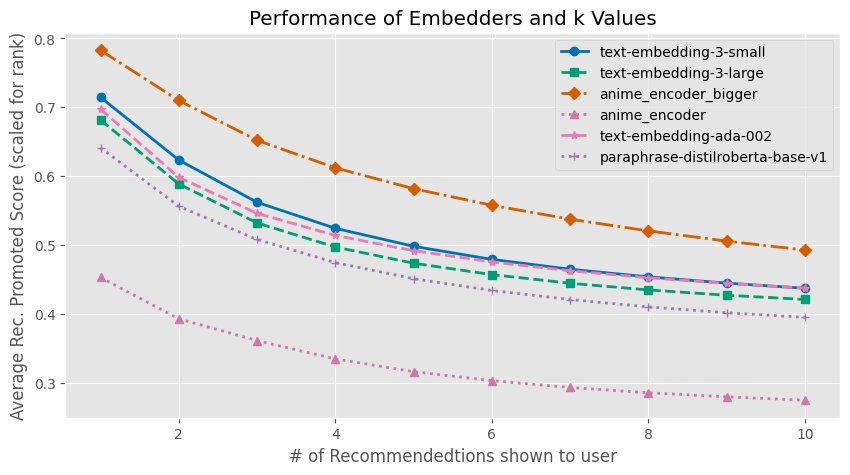

In [127]:
import matplotlib.pyplot as plt

# 데이터 추출
models = list(k_values[0].keys())
ks = [entry[models[0]]["k"] for entry in k_values]
model_avg_nps = {model: [entry[model]["avg_nps"] for entry in k_values] for model in models}

# 현대적인 스타일로 단일 그림 만들기
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 5))

# 색맹 친화적인 색상, 선 스타일 및 마커 스타일을 정의합니다.
colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7', '#EF79B2', '#A079B2']
line_styles = ['-', '--', '-.', ':', '--', ':']
marker_styles = ['o', 's', 'D', '^', '*', '+']

# 각 모델에 대한 플롯 라인
for idx, (model, avg_nps) in enumerate(model_avg_nps.items()):
    ax.plot(ks, avg_nps, label=model, linewidth=2, marker=marker_styles[idx], linestyle=line_styles[idx], color=colors[idx])

# 라벨, 제목, 범례 추가하기
ax.set_xlabel('# of Recommendedtions shown to user')
ax.set_ylabel('Average Rec. Promoted Score (scaled for rank)')
ax.set_title('Performance of Embedders and k Values')
ax.legend()

# 그래프 표시
plt.show()


In [130]:
model_avg_nps

{'text-embedding-3-small': [0.714660955305908,
  0.6234177700722647,
  0.5620151581496913,
  0.524277686910184,
  0.49809758377138724,
  0.4790795266748204,
  0.46477537972161803,
  0.4536785131913945,
  0.4446314143713542,
  0.43716813321352016],
 'text-embedding-3-large': [0.6816937923088002,
  0.5887103838539568,
  0.5320224634061669,
  0.49703630204821814,
  0.4735246811185211,
  0.45697351444177325,
  0.44442945832960284,
  0.4347164396579405,
  0.42702734604756953,
  0.4208757342309789],
 'anime_encoder_bigger': [0.7829597221595779,
  0.7099795085891568,
  0.6520359248443462,
  0.6120408343255296,
  0.581834120242649,
  0.5576940333817876,
  0.5374614444104517,
  0.520445939623289,
  0.505617601287048,
  0.4926502032588751],
 'anime_encoder': [0.45295315682281057,
  0.39276542133061976,
  0.3611368273071592,
  0.33445406943593664,
  0.31591845712577116,
  0.3029855154022619,
  0.29300132717282557,
  0.28532266079721424,
  0.2793665305991991,
  0.27451572682365033],
 'text-embeddi

In [91]:
df = pd.DataFrame(graph_scores_by_k).T

df

NameError: name 'graph_scores_by_k' is not defined